<a href="https://colab.research.google.com/github/marcolussetti/opendotadump-tools/blob/master/analysis/heroes_picks/GraphPicks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Hero Picks
This notebook will produce graphs of the heroes picked on a per-day basis.

## Processing

### Constants for configuration

In [0]:
CSV_INPUT_FILE = "https://raw.githubusercontent.com/marcolussetti/processopendota/master/data/heroes_picks_csvs/stable-picks_heroes-names_normalized.csv"
OPENDOTA_API_HEROES_ENDPOINT = "https://api.opendota.com/api/heroes/"

### Imports & Configuration

In [82]:
# If plotnine is not installed:
!pip install plotnine

# If using on google colab, might need to update statsmodels version
!pip install statsmodels -U

# If not installed
!pip install requests

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import pandas as pd
import requests
from plotnine import *
from scipy.spatial import distance
from datetime import datetime, timedelta

In [0]:
%matplotlib inline

### Import data

In [0]:
# Load input csv
df = pd.read_csv(CSV_INPUT_FILE, index_col=0)

In [0]:
# Load heroes data
heroes_json = requests.get("http://api.opendota.com/api/heroes/").json()
heroes = {hero["localized_name"]: hero for hero in heroes_json}

### Examine the data

#### Structure of dataset

In [6]:
df.head()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
2011-11-23,0.031486,0.017126,0.0,0.018552,0.017540,0.026369,0.024123,0.018658,0.030975,0.013213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-24,0.031408,0.016754,0.0,0.019774,0.017370,0.026447,0.023604,0.018433,0.031188,0.013667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-25,0.032189,0.016023,0.0,0.019135,0.017809,0.027230,0.023446,0.017764,0.029913,0.013325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-26,0.031530,0.015664,0.0,0.017849,0.017426,0.027688,0.022952,0.018812,0.030192,0.013363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-27,0.033113,0.016025,0.0,0.019733,0.017809,0.026345,0.023614,0.018145,0.031392,0.013036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.describe()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
count,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,...,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000
mean,0.014037,0.016291,0.005769,0.015230,0.012595,0.019619,0.015273,0.019029,0.015199,0.006720,...,0.002175,0.008366,0.003122,0.005518,0.002080,0.002349,0.002199,0.001082,0.001394,0.000379
std,0.005244,0.005581,0.002782,0.004036,0.002548,0.006944,0.004555,0.004342,0.004643,0.003288,...,0.002216,0.009084,0.004949,0.005609,0.002281,0.002949,0.002516,0.002373,0.002658,0.001800
min,0.004609,0.005743,0.000000,0.006873,0.004424,0.010537,0.003819,0.007236,0.005784,0.001659,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010392,0.013301,0.004188,0.012430,0.010751,0.015394,0.010884,0.016278,0.011641,0.004909,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.012597,0.015341,0.005909,0.014205,0.012510,0.018189,0.015820,0.017977,0.013427,0.005589,...,0.002304,0.009759,0.000000,0.006502,0.002072,0.002954,0.003260,0.000000,0.000000,0.000000
75%,0.016221,0.017192,0.007250,0.017893,0.013712,0.021558,0.018603,0.020105,0.019608,0.006986,...,0.003132,0.013347,0.005607,0.010028,0.003636,0.004012,0.004020,0.002338,0.003232,0.000000
max,0.048813,0.089076,0.050576,0.028260,0.028027,0.069269,0.026544,0.041925,0.031392,0.022744,...,0.044893,0.081352,0.061728,0.040209,0.028724,0.047423,0.038926,0.050782,0.037872,0.044581


#### Overall heroes  metrics

In [0]:
# Most popular heroes overall (mean)
heroes_most_popular = df.mean().sort_values(ascending=False)[:10]  # Average of normalized pick frequency
heroes_most_popular

heroes_most_popular = df.mean().sort_values(ascending=False)[:]  # Average of normalized pick frequency

In [88]:
# Heroes with the most variation
heroes_most_variation = df.std().sort_values(ascending=False)[:10]  # Standard deviation of pick frequency
heroes_most_variation

Phantom Assassin    0.009263
Legion Commander    0.009084
Invoker             0.007350
Slark               0.006973
Drow Ranger         0.006944
Sniper              0.006183
Troll Warlord       0.006128
Windranger          0.006074
Bounty Hunter       0.005629
Ember Spirit        0.005609
dtype: float64

In [89]:
# Heroes with the least variation
heroes_least_variation = df.std().sort_values(ascending=False)[:10]  # Standard deviation of pick frequency
heroes_least_variation

Phantom Assassin    0.009263
Legion Commander    0.009084
Invoker             0.007350
Slark               0.006973
Drow Ranger         0.006944
Sniper              0.006183
Troll Warlord       0.006128
Windranger          0.006074
Bounty Hunter       0.005629
Ember Spirit        0.005609
dtype: float64

#### Exploratory graphing

In [0]:
df_with_date_col = df.copy(deep=True)
df_with_date_col = df_with_date_col.reset_index(level=0)
df_with_date_col.columns = ["Date", *df_with_date_col.columns[1:]]

In [12]:
df_with_date_col.head()

,Date,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2011-11-23,0.031486,0.017126,0.0,0.018552,0.017540,0.026369,0.024123,0.018658,0.030975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-11-24,0.031408,0.016754,0.0,0.019774,0.017370,0.026447,0.023604,0.018433,0.031188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-11-25,0.032189,0.016023,0.0,0.019135,0.017809,0.027230,0.023446,0.017764,0.029913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-11-26,0.031530,0.015664,0.0,0.017849,0.017426,0.027688,0.022952,0.018812,0.030192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-11-27,0.033113,0.016025,0.0,0.019733,0.017809,0.026345,0.023614,0.018145,0.031392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotni

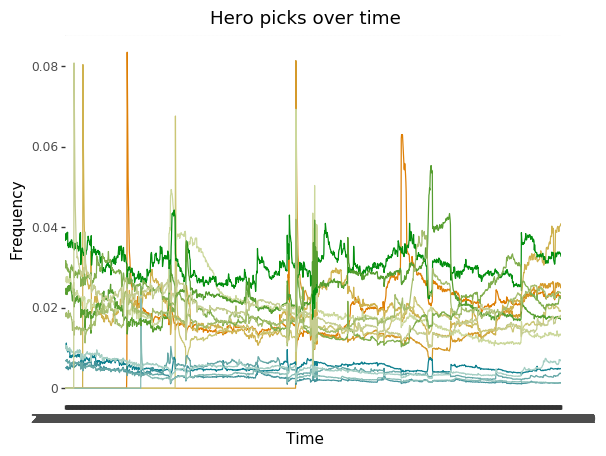

<ggplot: (8740336791437)>

In [13]:
basic_plot = (ggplot(df_with_date_col, aes())
 # Highest variance
 +geom_line(aes('Date', 'Phantom Assassin', group=1), color='#de7f05')
 +geom_line(aes('Date', 'Legion Commander', group=1), color='#d59a2b')
 +geom_line(aes('Date', 'Invoker', group=1), color='#cfb24f')
 +geom_line(aes('Date', 'Slark', group=1), color='#cbc675')
 +geom_line(aes('Date', 'Drow Ranger', group=1), color='#ccd89c')
 # Lowest variance
 +geom_line(aes('Date', 'Pugna', group=1), color='#0f808f')
 +geom_line(aes('Date', 'Chen', group=1), color='#42939a')
 +geom_line(aes('Date', 'Batrider', group=1), color='#65a7a6')
 +geom_line(aes('Date', 'Visage', group=1), color='#85bbb4')
 +geom_line(aes('Date', 'Enchantress', group=1), color='#a4cec3')
 # Highest popularity (skipping already used ones)
 +geom_line(aes('Date', 'Pudge', group=1), color='#038f0f')
 +geom_line(aes('Date', 'Sniper', group=1), color='#569e30')
 +geom_line(aes('Date', 'Windranger', group=1), color='#81ae4e')
 +geom_line(aes('Date', 'Juggernaut', group=1), color='#a5bd6e')
 +geom_line(aes('Date', 'Bounty Hunter', group=1), color='#c5cd91')
 #Config
 +ggtitle("Hero picks over time")
 +ylab("Frequency")
 +xlab("Time")
)
basic_plot

#### Reformat data for "easy" graphing

In [0]:
df_expl_graph = df.copy(deep=True)
# Condense values
df_expl_graph = df_expl_graph.stack()
df_expl_graph = df_expl_graph.reset_index()

df_expl_graph.columns = ["Day", "Hero", "Frequency"]

df_expl_graph["Day"] = df_expl_graph["Day"].apply(pd.to_datetime)

df_expl_graph["Week"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.week))
df_expl_graph["Month"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.month))
df_expl_graph["Year"] = df_expl_graph["Day"].apply(lambda date: date.year)


In [91]:
df_expl_graph.head()

,Day,Hero,Frequency,Week,Month,Year
0,2011-11-23,Anti-Mage,0.031486,2011-47,2011-11,2011
1,2011-11-23,Axe,0.017126,2011-47,2011-11,2011
2,2011-11-23,Bane,0.000000,2011-47,2011-11,2011
3,2011-11-23,Bloodseeker,0.018552,2011-47,2011-11,2011
4,2011-11-23,Crystal Maiden,0.017540,2011-47,2011-11,2011


In [0]:
df_most_popular_graph = df_expl_graph[df_expl_graph["Hero"].isin(heroes_most_popular.keys())]

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


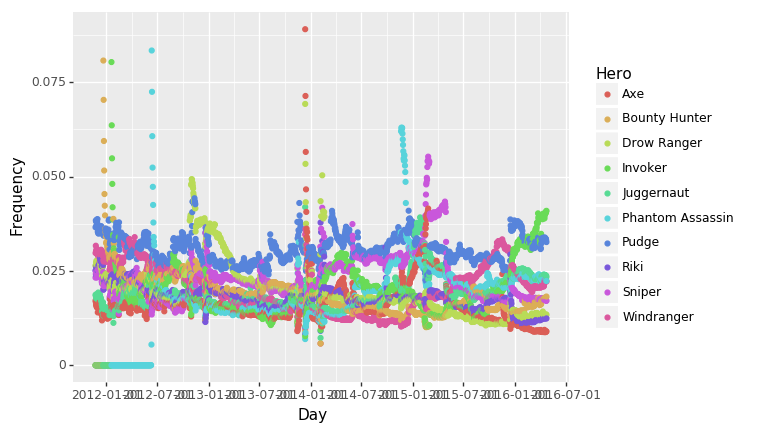

<ggplot: (-9223363274373508078)>

In [220]:
day_plot = (ggplot(df_most_popular_graph, aes(x="Day", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
day_plot

In [221]:
day_plot.save("most_popular_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


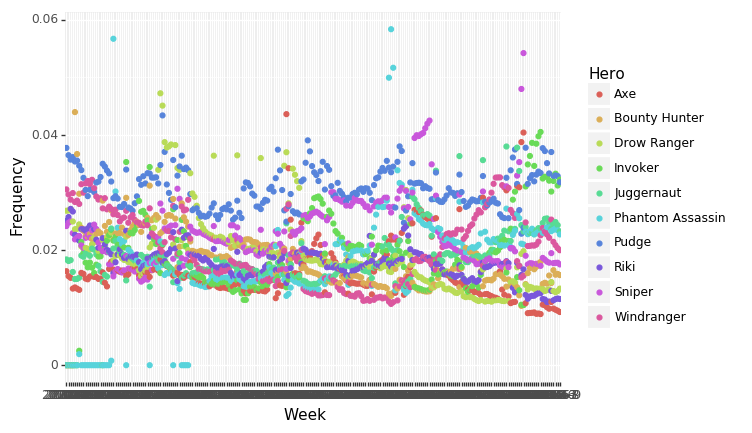

<ggplot: (8762478023828)>

In [222]:
week_plot = (ggplot(df_most_popular_graph.groupby(["Week", "Hero"]).mean().reset_index(), aes(x="Week", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
week_plot

In [223]:
week_plot.save("most_popular_week_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_week_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


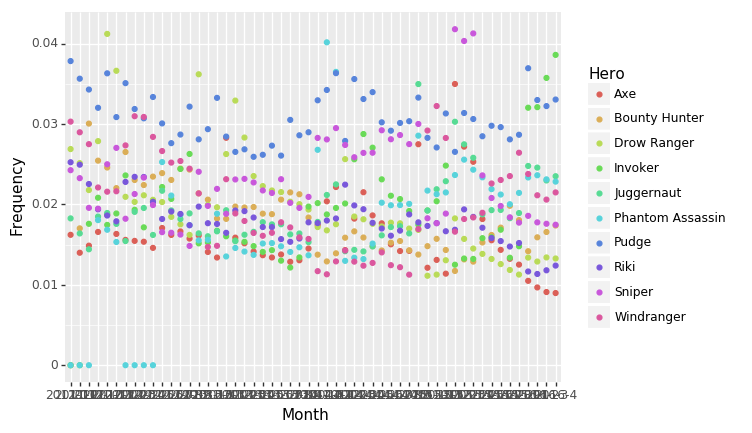

<ggplot: (8762481074787)>

In [224]:
month_plot = (ggplot(df_most_popular_graph.groupby(["Month", "Hero"]).mean().reset_index(), aes(x="Month", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
month_plot

In [225]:
month_plot.save("most_popular_month_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_month_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


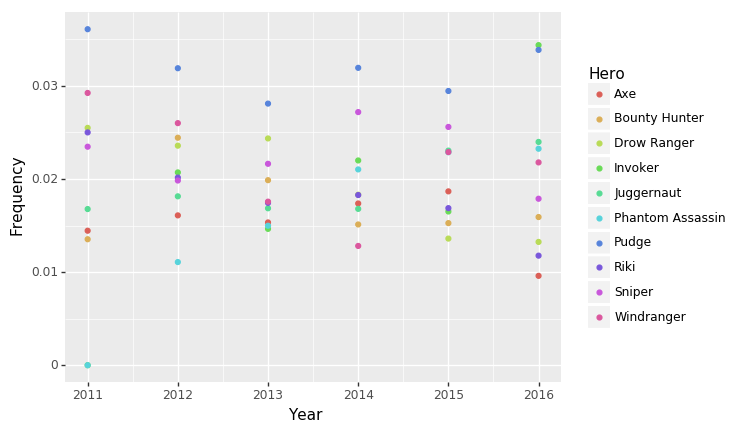

<ggplot: (8762473742677)>

In [226]:
year_plot = (ggplot(df_most_popular_graph.groupby(["Year", "Hero"]).mean().reset_index(), aes(x="Year", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
year_plot

In [227]:
year_plot.save("most_popular_year_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_year_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


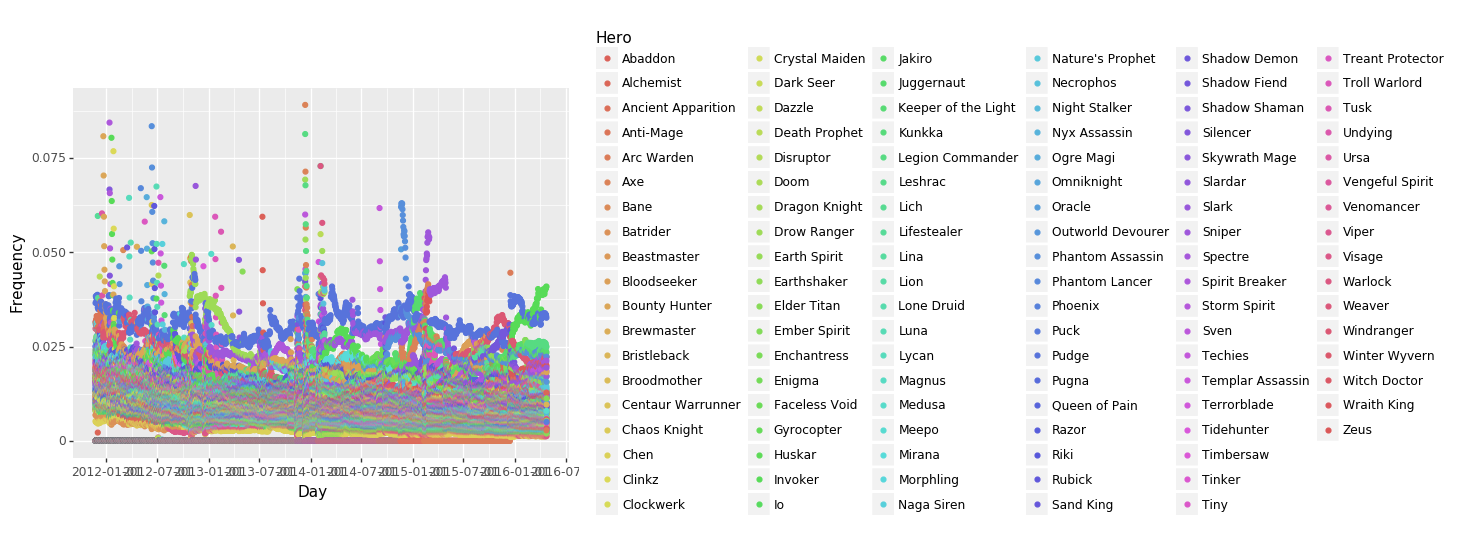

<ggplot: (-9223363274384512680)>

In [228]:
all_day_plot = (ggplot(df_expl_graph, aes(x="Day", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
all_day_plot

In [229]:
all_day_plot.save("all_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


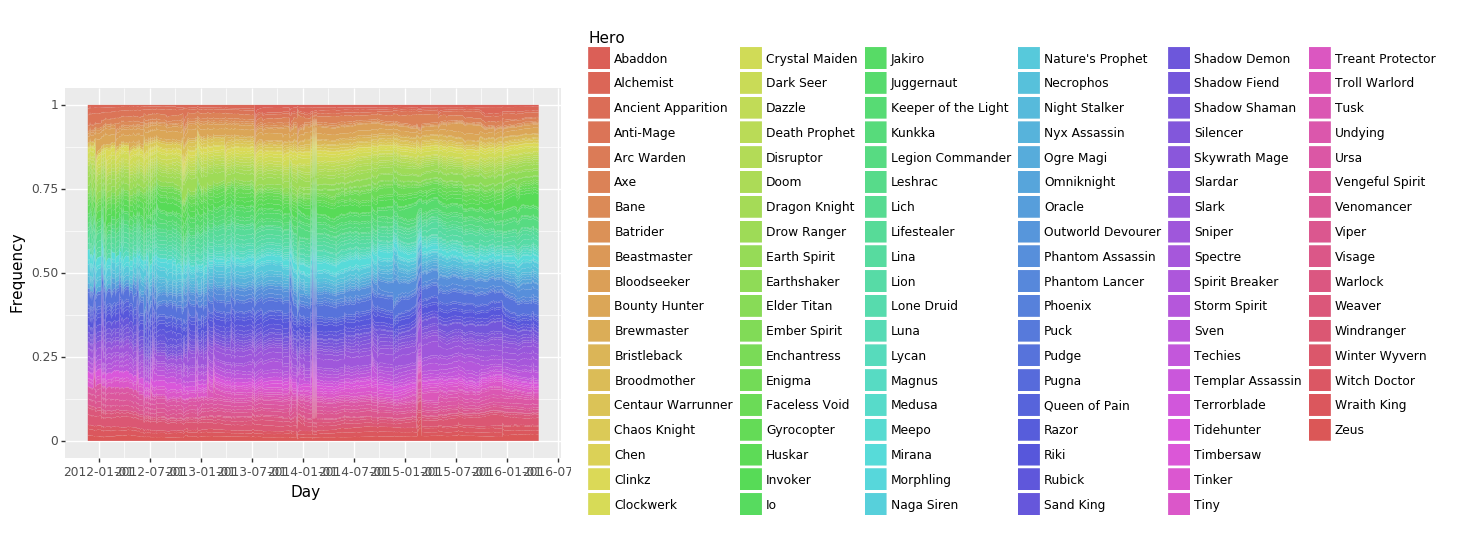

<ggplot: (8762474247579)>

In [230]:
all_day_stacked_plot = (ggplot(df_expl_graph, aes(x="Day", y="Frequency"))
              +geom_area(aes(fill="Hero"))
             )
all_day_stacked_plot

In [231]:
all_day_stacked_plot.save("all_day_stacked_plot.png", width=44, height=12, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 12 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_day_stacked_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


#### Detect changes over time

In [0]:
def previous_distribution_vector(df, date_start, date_end, average_function="mean"):
  df_filtered = df[(df["Day"] >= date_start) & (df["Day"] < date_end)]
  
  if average_function == "median":
    result = df_filtered.groupby(["Hero"]).median()[["Frequency"]]
  else:
    result = df_filtered.groupby(["Hero"]).mean()[["Frequency"]]
  
  return result.to_dict()["Frequency"]

In [0]:
def compute_distance(day, previous_period_average, distance_function=distance.euclidean, weighted=False):
  previous = [value for key, value 
              in sorted(previous_period_average.items(), key=lambda x: x[0])]
  current = [value for key, value 
              in sorted(day.items(), key=lambda x: x[0])]
  assert len(previous) == len(current), "Incorrect length: previous-> {}, current-> {}".format(len(previous), len(current))
  if weighted:
    return distance_function(previous, current, previous)
  else:
    return distance_function(previous, current)
  

In [0]:
def day_difference(df, day, distance_function=distance.euclidean, length=14, average_function="mean", weighted=False):
  # Extract vector for day
  day_picks = {record["Hero"]: record["Frequency"] for record 
               in df[df["Day"] == day][["Hero", "Frequency"]].to_dict('records')
              }
  previous_picks = previous_distribution_vector(df, datetime.strptime(day, '%Y-%m-%d') - timedelta(days=length), day, average_function)
  
  return compute_distance(day_picks, previous_picks, distance_function, weighted)

In [0]:
def all_days_difference(df, distance_function=distance.euclidean, length=14, average_function="mean", weighted=False):
  all_days = [str(d) for d in sorted(set(date.date() for key, date in df["Day"].to_dict().items()))[1:]]
  
  return {day: day_difference(
      df, day, distance_function=distance_function, 
      length=length, average_function="mean") 
   for day in all_days}

In [97]:
# Try to graph differences for top 10 champions by popularity

pop_differences_by_day = all_days_difference(df_most_popular_graph).items()
sorted_pop_differences_by_day = sorted(pop_differences_by_day, key=lambda x: x[1], reverse=True)
df_pop_differences_by_day = pd.DataFrame(pop_differences_by_day)
df_pop_differences_by_day.columns = ["Day", "Difference"]
df_pop_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.005370
1,2011-11-25,0.004699
2,2011-11-26,0.005136
3,2011-11-27,0.004251
4,2011-11-28,0.004513


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


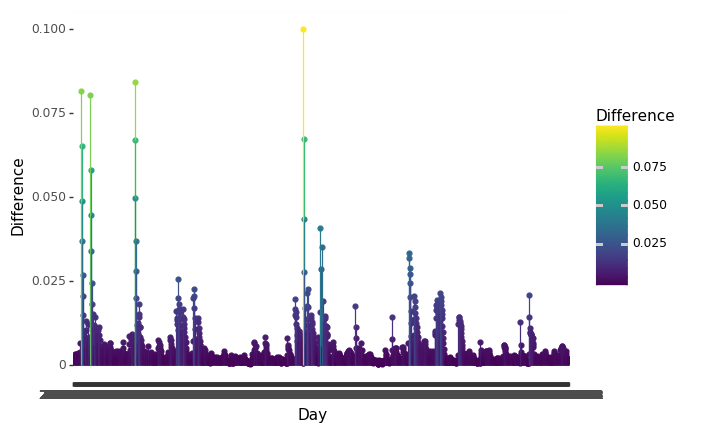

<ggplot: (-9223363274383043142)>

In [237]:
popular_heroes_differences_plot = (
    ggplot(df_pop_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

popular_heroes_differences_plot

In [239]:
popular_heroes_differences_plot.save("pop_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: pop_differences_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [98]:
# Try to graph differences for all heroes

all_differences_by_day = all_days_difference(df_expl_graph).items()
sorted_all_differences_by_day = sorted(all_differences_by_day, key=lambda x: x[1], reverse=True)
df_all_differences_by_day = pd.DataFrame(all_differences_by_day)
df_all_differences_by_day.columns = ["Day", "Difference"]
df_all_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.005370
1,2011-11-25,0.004699
2,2011-11-26,0.005136
3,2011-11-27,0.004251
4,2011-11-28,0.004513


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


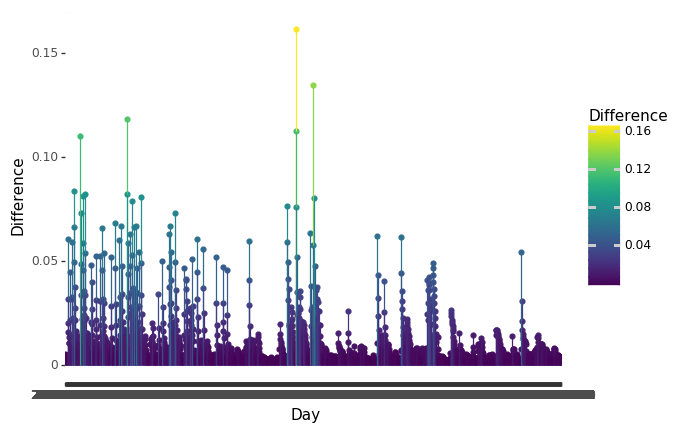

<ggplot: (-9223363296517950327)>

In [99]:
all_heroes_differences_plot = (
    ggplot(df_all_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_heroes_differences_plot

In [242]:
all_heroes_differences_plot.save("all_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_differences_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [247]:
# What if we weight it?
# Try to graph differences for all heroes

all_differences_by_day_weighted = all_days_difference(df_expl_graph, weighted=True).items()
sorted_all_differences_by_day_weighted = sorted(all_differences_by_day_weighted, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_weighted = pd.DataFrame(all_differences_by_day_weighted)
df_all_differences_by_day_weighted.columns = ["Day", "Difference"]
df_all_differences_by_day_weighted.head()

,Day,Difference
0,2011-11-24,0.005370
1,2011-11-25,0.004699
2,2011-11-26,0.005136
3,2011-11-27,0.004251
4,2011-11-28,0.004513


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


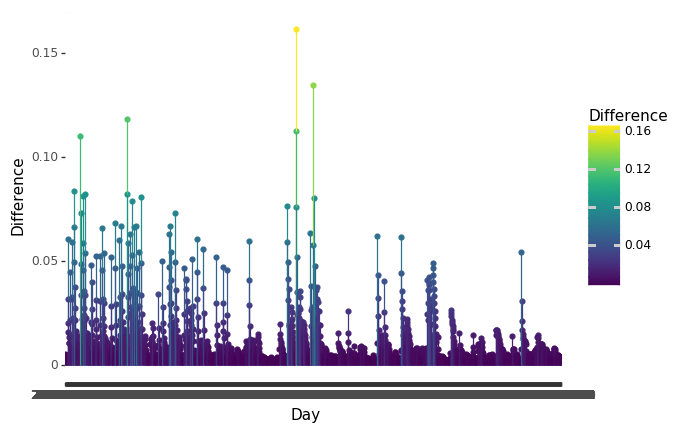

<ggplot: (8762481713135)>

In [248]:
all_heroes_differences_weighted_plot = (
    ggplot(df_all_differences_by_day_weighted, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_heroes_differences_weighted_plot

In [249]:
all_heroes_differences_plot.save("all_differences_weighted_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_differences_weighted_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [262]:
# Try to graph differences for all heroes, 28 days

all_differences_by_day_28 = all_days_difference(df_expl_graph, length=28).items()
sorted_all_differences_by_day_28 = sorted(all_differences_by_day_28, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_28 = pd.DataFrame(all_differences_by_day_28)
df_all_differences_by_day_28.columns = ["Day", "Difference"]
df_all_differences_by_day_28.head()

,Day,Difference
0,2011-11-24,0.005370
1,2011-11-25,0.004699
2,2011-11-26,0.005136
3,2011-11-27,0.004251
4,2011-11-28,0.004513


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


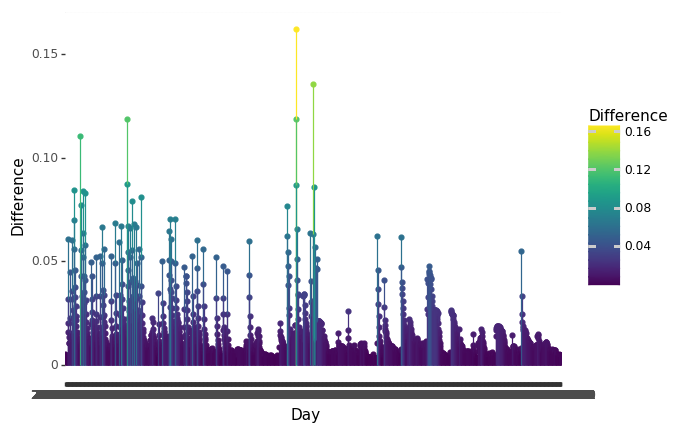

<ggplot: (-9223363274381536487)>

In [263]:
all_differences_by_day_28_plot = (
    ggplot(df_all_differences_by_day_28, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_differences_by_day_28_plot

In [264]:
all_differences_by_day_28_plot.save("all_differences_28_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_differences_28_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [100]:
# Try to graph differences for all heroes, manhattan distance

all_differences_by_day_manhattan = all_days_difference(df_expl_graph, distance_function=distance.cityblock).items()
sorted_all_differences_by_day_manhattan = sorted(all_differences_by_day_manhattan, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_manhattan = pd.DataFrame(all_differences_by_day_manhattan)
df_all_differences_by_day_manhattan.columns = ["Day", "Difference"]
df_all_differences_by_day_manhattan.head()

,Day,Difference
0,2011-11-24,0.031028
1,2011-11-25,0.029141
2,2011-11-26,0.031899
3,2011-11-27,0.024759
4,2011-11-28,0.027122


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


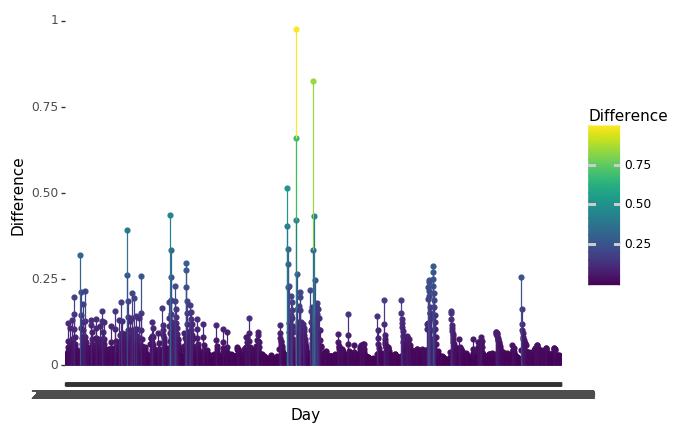

<ggplot: (8740336832246)>

In [101]:
all_heroes_differences_manhattan_plot = (
    ggplot(df_all_differences_by_day_manhattan, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_heroes_differences_manhattan_plot

In [46]:
all_heroes_differences_manhattan_plot.save("all_differences_manhattan_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: all_differences_manhattan_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


## Poster graphs

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 16872 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


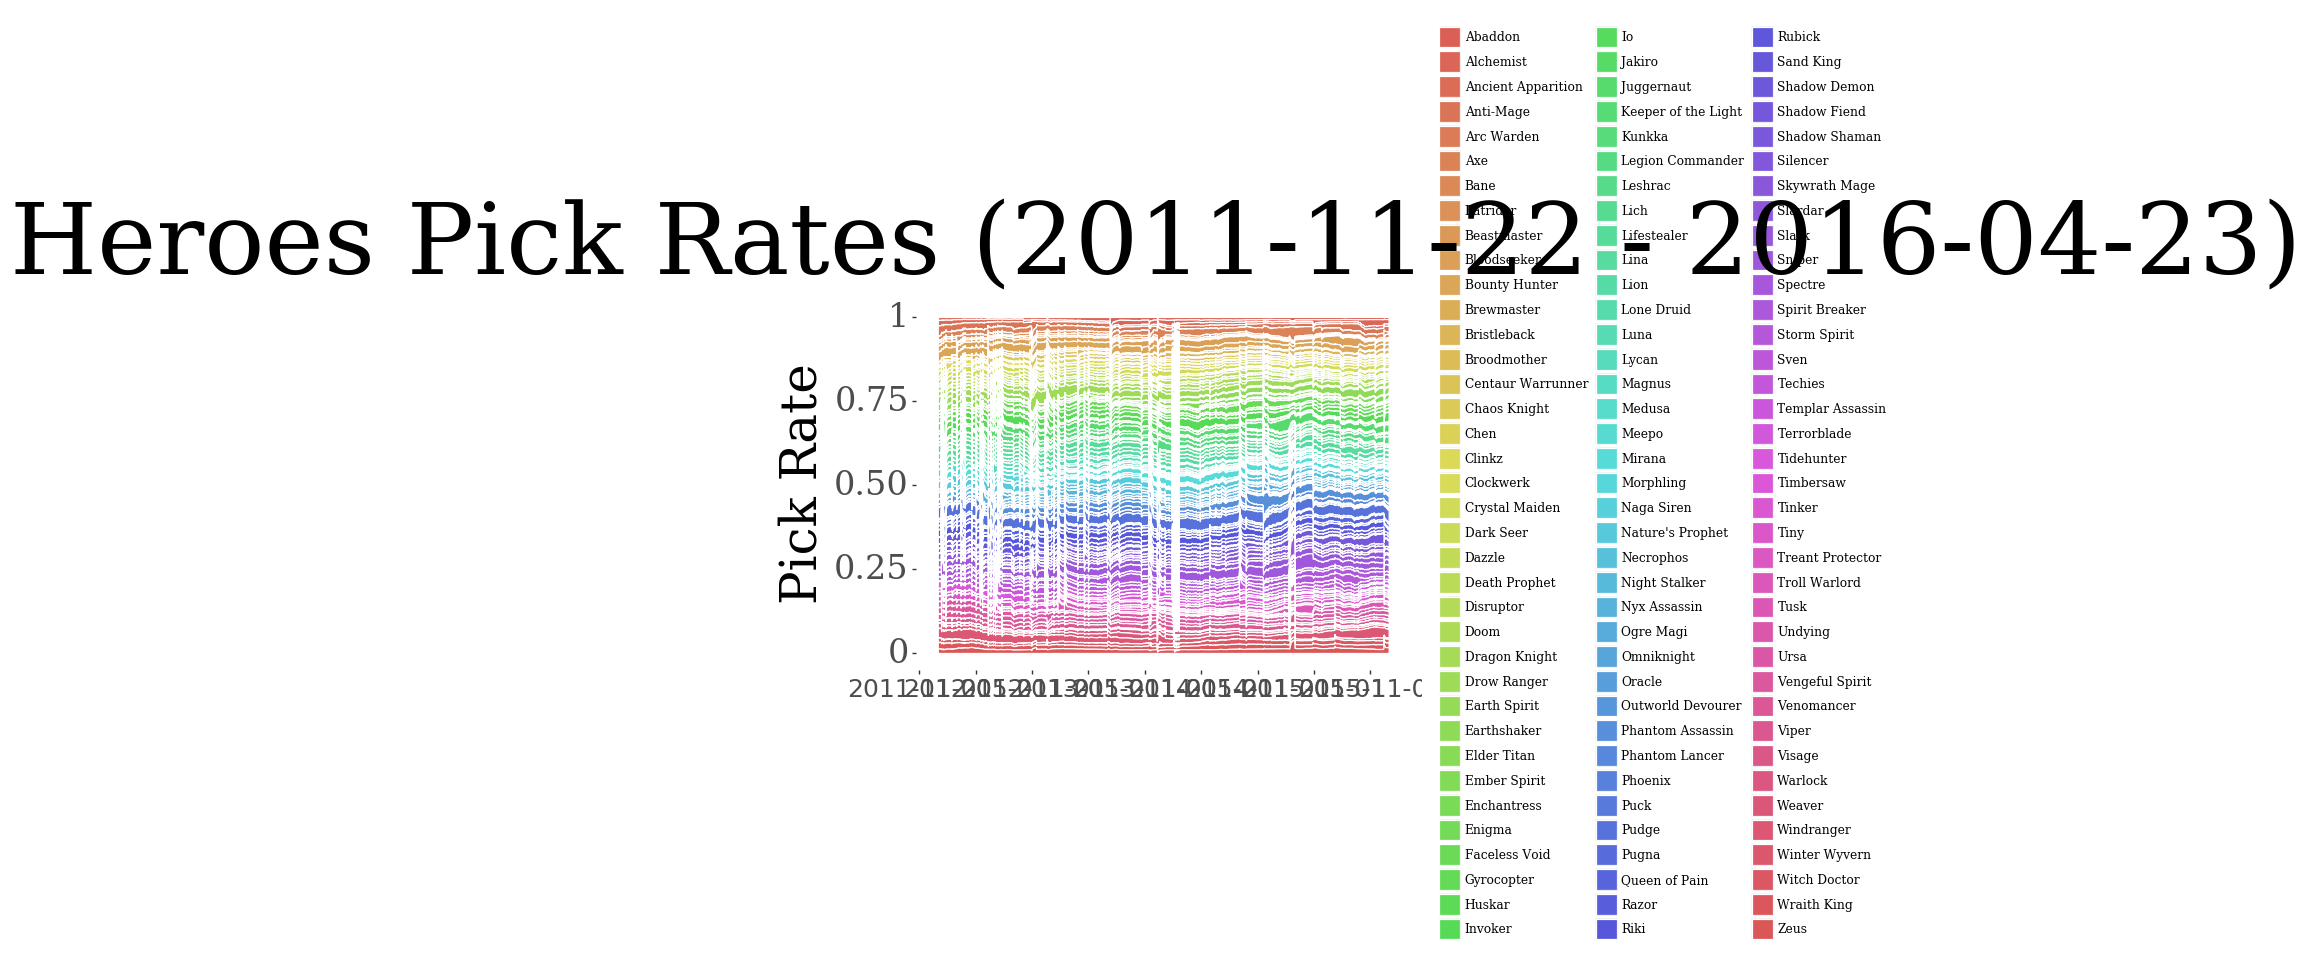

<ggplot: (-9223363296519076520)>

In [142]:
poster_stacked = (
    ggplot(df_expl_graph, aes(x="Day", y="Frequency"))
    +geom_area(aes(fill="Hero"), color="white")
    +guides(fill=guide_legend(ncol=3, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Heroes Pick Rates (2011-11-22 - 2016-04-23)")
    +xlab("")
    +ylab("Pick Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=24.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=72.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu']),#, angle=45),
        panel_background=element_rect(fill="white", colour="white"),
    )
)
poster_stacked

In [143]:
poster_stacked.save("poster_stacked_white.png", width=44, height=12, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 12 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_stacked_white.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 16872 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


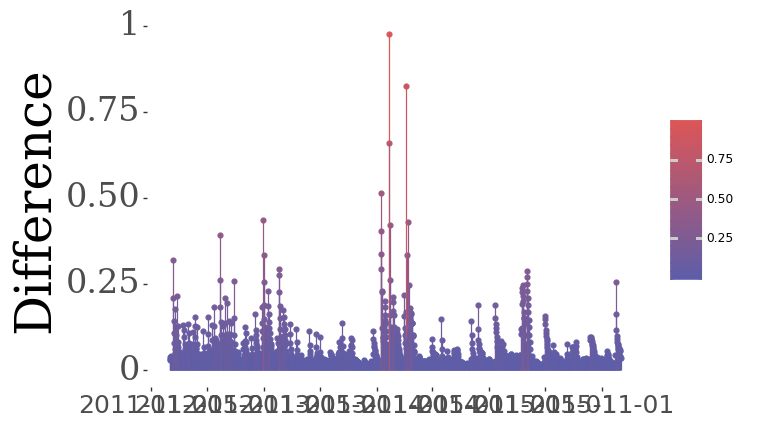

<ggplot: (-9223363296528502542)>

In [147]:
poster_differences_plot = (
    ggplot(df_all_differences_by_day_manhattan, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
    +scale_color_gradient(low="#5D5DA9", high="#DC5657")
    +scale_fill_gradient(low="#5D5DA9", high="#DC5657")
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +xlab("")
    +theme(
        text=element_text(family=['serif']),
        panel_background=element_rect(fill="white", colour="white"),
        panel_grid=element_blank(),
        axis_text=element_text(size=24.0),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu']),
        legend_text=element_text(family=['Dejavu Sans', 'Dejavu']),
        legend_title=element_blank(),
    )
)

poster_differences_plot

In [148]:
poster_differences_plot.save("poster_differences_white.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_differences_white.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 rows containing miss